**Fiche d'exercice n°1**

Cette fiche d'exercices doit permettre de :
- s'entraîner au devoir de janvier
- compléter votre culture dans le domaine

La correction sera mise à disposition autour du 11/11.

**Question 1** Nous avons vu qu'il était impossible de séparer les nuages de points du TP1/partie I/B avec un perceptron une couche. Mais c'est parce que nous nous sommes limités à deux prédicteurs, l'abscisse $x$ et l'ordonnée $y$. Quels autres prédicteurs peut-on utiliser pour résoudre le problème sans ajouter de couches au perceptron ?
  

**Question 2** A quel modèle statistique correspond un perceptron à une couche avec une fonction d'activation sigmoïde ?
Citer une bibliothèque python qui permet d'appliquer ce modèle à un jeu de données.

**Question 3** Combien un VGG16 contient-il de paramètres dans les couches de convolutions ? Dans les couches complètement connectées ?
Appuyer par un bout de code.

**Question 4** Visualiser la première couche d'un VGG entraîné sur ImageNet. Commenter.

**Question 5** Quel est l'effet d'un dropout sur les couches complètement connectées ? Illustrer sur un perceptron à une couche avec quelques lignes de codes.

**Problème 1** Classification avec cibles bruitées

Les utilisateurs du Machine Learning font souvent face à un problème de qualité des cibles.
Dans ce court problème, on se propose de mesurer l'effet de cibles bruitées sur les performances en généralisation d'un CNN.


Pour une comparaison propre, nous allons d'abord scinder en trois jeux le dataset MNIST :


In [ ]:
import torchvision
from torchvision import datasets
import torch
from torch.utils.data import random_split, Dataset, DataLoader
root = '/content/drive/MyDrive/TP_ENM/data'

#Définition des jeux d'apprentissage:
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])


ds_trainval = datasets.MNIST(root='MNIST', download=True, train=True)
ds_test = datasets.MNIST(root='MNIST', download=True, train=False)



len_trainval = len(ds_trainval)
len_train = round(0.8 * len_trainval)
len_val = len_trainval - len_train
subset_train, subset_val = random_split(ds_trainval,
                                [len_train, len_val],
                                generator=torch.Generator().manual_seed(1))

In [ ]:
#Split aléatoire en deux datasets (80% train, 20% val):
class SubDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
ds = {}
ds['train'] = SubDataset(subset_train, tr)
ds['val'] = SubDataset(subset_val, tr)
ds['test'] = ds_test
loader = {x : DataLoader(ds[x], batch_size=32, shuffle=True, num_workers = 2) for x in ds.keys()}

**Question 6**  Quelles sont les tailles des différents jeux de données ? A quoi sert-il de fixer le générateur de nombres aléatoires dans random_split ?

**Question 7** Reprendre le CNN du TP2/partie1 et la fonction train_model_gpu vue au TP2/partie2.
- Ajouter une procédure de sélection de modèle à partir des performances sur le jeu de validation.
- Coder une fonction test_model_gpu() qui calcule la justesse sur le jeu de test.
- Faire tourner l'apprentissage sur 50 époques, avec l'optimiser ADAM, paramétré de manière standard.

Quelles sont les performances sur le jeu de test du modèle sélectionné ? \\


**Question 8** Quel est l'effet de la fonction suivante sur un batch de cibles ?

In [ ]:
def flipping_label(labels, p):
  #Sélection aléatoire des composantes
  flip_probas = p * torch.ones(labels.shape)
  flip_or_not = torch.bernoulli(flip_probas) == 1
  random_labels = torch.randint(0,10,labels.shape).to(device)
  labels[flip_or_not] = random_labels[flip_or_not]



labels = torch.randint(0,10,(32,)).to(device)
print(labels)

# niveau de bruit :
p = 0.5

# Après bruitage :
flipping_label(labels, p)
print(labels)

**Question 9** Définir une procédure d'entraînement "bruitée" à partir de flipping_labels() (ne bruiter que la phase d'entraînement). Quel est l'effet sur les performances en fonction du niveau de bruit ?

**Problème 2** Le chat perturbé


Reprendre l'image de chat du TP2 et la bruiter de manière à ce que :
- le chat soit encore parfaitement reconnaissable
- le VGG16 vu au TP2 se trompe complètement de classe.

Vous pourrez par exemple dégrader la résolution et modifier localement la valeur de certains pixels. En vous renseignant un peu sur les "attaques adversariales", vous verrez comment aborder le problème par des techniques d'optimisation bien choisies. \\
L'image "disrupted_cat.jpg" du répertoire "exercises" fournit un exemple de solution. Les cellules ci-dessous permettent de le vérifier.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

model = models.vgg16(pretrained=True)
model = model.cuda()
softmx = nn.Softmax(dim=1).cuda()
model.eval()


In [ ]:
def imshow(inp, title=None, save_path=None):
    if save_path is not None:
        torch.save(inp, save_path)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

classe prédite : 333 (hamster)


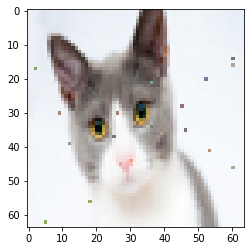

In [ ]:
## Après optimisation voici une configuration qui arrive à tromper le modèle
path = 'Ou/est/disrupted_cat.jpg'
dcat = torch.load(path)
imshow(dcat)

dcat = dcat.unsqueeze(dim=0).cuda()
output_dcat = softmx(model(dcat)).squeeze(dim=0)
pred_dcat = torch.max(output_dcat, dim=0)[1].item()
print("classe prédite : " + str(pred_dcat) + " (hamster)")